# Parametric Simulation: Weibull with Non-linear predictors

Setup chunk:

In [3]:
import numpy as np
from scipy.stats import weibull_min # r weibull simulation
from scipy.stats import norm # for covariate simulation
from scipy.stats import gamma # for weibull shape parameter
from scipy.stats import bernoulli # for censoring
from scipy.stats import uniform
from scipy.stats.mstats import mquantiles
import pandas as pd

## Simulated data
In this section, we define and check a function to simulate survival data from a Weibull distribution using a linear predictor given by:
\begin{equation}
  t_i \sim \text{Weib}(\kappa,\lambda e^{\phi(x_i)}),
\end{equation}
\begin{equation}
  \lambda = 1, \quad \kappa \sim 5,
\end{equation}
\begin{equation}
  x_{i} \sim F_x,
\end{equation}
$\phi: \mathbb{R} \rightarrow \mathbb{R}$ is some function, and $F_x$ is a given probability density.
Censoring is modelled by:
- *Simulate end of follow-up period:* $p_\text{dropout} \sim 0.2$.  $q = \frac{1 - p_\text{censor}}{1 - p_\text{dropout} p_\text{censor}}$. If $\hat{F}(t_i) > q$, set $t_i \rightarrow t_i^\prime F^-(q)$. (I.e. set all times above $q$th quantile to $q$th quantile.)
-*Simulate random drop-out:* If $\hat{F}(t_i) <= q$, let $d_i \sim \text{Bern}(p_\text{dropout} p_\text{censor})$ be the indicator variable for dropping out. If $\delta_i = 1$, then $t_i \rightarrow t_i^\prime \sim \mathcal{U}(0,t_i)$.

Note that the `scipy.stats.weibull_min` uses the parameterisation of the Weibull distribution:
\begin{align}
f(t) = \frac{k}{l}(\frac{t}{l})^{k - 1} e^{-(t/l)^k}.
\end{align}
Hence, we set $k = \kappa$ and $l =  e^{-x_i^T \beta/k}$.

### Simultion function

In [1]:
def weibull_nonlinear_sim(phi, F_x, obs, censor_prop):
    # phi: vectorised non-linear transformation
    # obs: number of observations to simulate
    # censor_prop: proportion of individuals to censored
    # show_beta: prints the linear coefficient used in the simulation (for testing function)
    
    # matrix of normal covariates
    X = F_x
    phi_X = phi(X)
    
    # shape parameter of weibull
    c = 5
    
    # creating a dataframe for the simulation
    sim_data = pd.DataFrame(phi_X)
    # simulating survival times from weibull distribution
    sim_data["y"] = weibull_min.rvs(c, scale = np.exp(-phi_X/c)) 

    # proportion of censors caused by dropping out
    dropout_prop = 0.2
    # quantile above which we censor
    max_time = float(mquantiles(sim_data["y"], prob = (1 - censor_prop)/(1 - dropout_prop*censor_prop)))
    # censoring indicator invdividuals above the quantile
    sim_data["end_censor"] = np.where(sim_data["y"] > max_time,True,False)
    # dropout indicator for individuals not censored by end censoring
    sim_data["dropout"] = np.where(sim_data["end_censor"] == False, bernoulli.rvs(p = dropout_prop*censor_prop, size = len(sim_data)) == 1, False)
    # "end censoring" times
    sim_data["end_censor_time"] = np.where(sim_data["y"] > max_time, max_time, sim_data["y"])
    # simulating the dropout time
    sim_data["time"] = np.where(sim_data["dropout"], uniform.rvs(scale = sim_data["end_censor_time"]), sim_data["end_censor_time"])

    sim_data["event"] = ~(sim_data["dropout"] | sim_data["end_censor"]) 
    
    return(sim_data)

In [4]:
weibull_nonlinear_sim(np.exp, norm.rvs(size = 20), 20, 0.7)

,0,y,end_censor,dropout,end_censor_time,time,event
0,1.065716,0.814875,True,False,0.695658,0.695658,False
1,1.882446,0.837463,True,False,0.695658,0.695658,False
2,0.070848,0.838886,True,False,0.695658,0.695658,False
3,1.008671,0.726774,True,False,0.695658,0.695658,False
4,0.757067,0.665377,False,False,0.665377,0.665377,True
5,0.386085,0.919356,True,False,0.695658,0.695658,False
6,0.346425,0.900687,True,False,0.695658,0.695658,False
7,0.270522,0.908399,True,False,0.695658,0.695658,False
8,0.818185,1.260026,True,False,0.695658,0.695658,False
9,0.504608,0.564665,False,True,0.564665,0.481113,False


## Tests

Let us check that the distribution of the covariates is as expected for different specified generation process via plots:

In [5]:
import matplotlib.pyplot as plt

$\phi = \exp$, $x_i \sim \mathcal{N}(0,1)$.

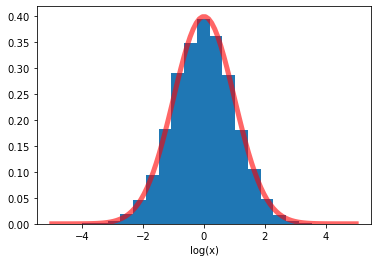

In [6]:
predictors = np.log(weibull_nonlinear_sim(np.exp, norm.rvs(size = 10000), 10000, 0.7)[0])

fig,ax = plt.subplots(1,1)
ax.hist(predictors, density = True, bins = 20)
x = np.linspace(-5,5,100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='normal pdf')
ax.set_xlabel('log(x)')
plt.show()

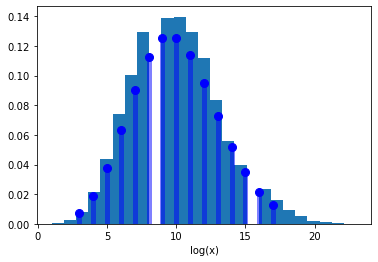

In [7]:
from scipy.stats import poisson

mu = 10
predictors = np.exp(weibull_nonlinear_sim(np.log, poisson.rvs(mu,size = 10000) + 1, 10000, 0)[0]) - 1

fig,ax = plt.subplots(1,1)
ax.hist(predictors, density = True, bins = 25)
x = np.arange(poisson.ppf(0.01, mu),
              poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)
ax.set_xlabel('log(x)')
plt.show()